<a href="https://colab.research.google.com/github/4nchez/Colab-Jupiter/blob/master/%EB%84%A4%EC%9D%B4%EB%B2%84_%EC%98%81%ED%99%94_%ED%8F%89%EA%B0%80_%EA%B0%90%EC%84%B1%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Huggingface 소개

![대체 텍스트](https://i.imgur.com/6DM516z.png)  
![대체 텍스트](https://i.imgur.com/g6R67h4.png)    
https://huggingface.co/transformers/ 

HuggingFace는 자연어 처리 인공지능 모델에서, BERT 모델 같은 트랜스포머 모델들을 쉽게 다룰 수 있게 해주는 패키지입니다.  
기본적으로 pytorch 기반으로 만들어져 있지만, 텐서플로우 2.0에서도 본 패키지를 사용 가능합니다.  
텐서플로우 2.0은 기존 케라스를 포함하고 있기 때문에, 기존 텐서플로우나 케라스에 익숙하신 분들이 쉽게 사용할 수 있습니다.  
텐서플로우 2.0 기반의 huggingface 사용 방법을 네이버 영화 긍부정 분석을 실습하면서 배워 보도록 하겠습니다.

#목차
이번 실습은 <b>1) 네이버 감성분석 데이터 불러오기 및 전처리 2) BERT 인풋 만들기 3) 버트를 활용한 감성분석 모델 만들기 4) 훈련 및 성능 검증 5) 실제 데이터로 실습하기</b>로 구성되어 있습니다.

#BERT를 활용하여 네이버 감성분석 만들기

## 네이버 감성분석 데이터 불러오기 및 전처리

In [3]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



huggingface 패키지를 Colab에 설치합니다

In [4]:
!pip install transformers

     |████████████████████████████████| 890kB 3.4MB/s 
     |████████████████████████████████| 890kB 18.6MB/s 
     |████████████████████████████████| 3.0MB 28.5MB/s 
     |████████████████████████████████| 1.1MB 54.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=7d9f748a89a68e9033435c7978286ffa53152de0abf22bce4aee97d5443516b2
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


텐서플로우 2와 필요한 모듈들을 임포트합니다.  
최근에 텐서플로우 기본 버전은 2로 바뀌었습니다.

In [5]:
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import *
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import os

bert 모델 다운

In [6]:
# wget을 활용해서 bert 모델 다운로드 가능
import os
# if "multi_cased_L-12_H-768_A-12.zip" not in os.listdir():
#   !wget https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip
#   if "bert" not in os.listdir():
#     os.makedirs("bert")
#   else:
#     pass

#   import zipfile
#   import shutil
          
#   bert_zip = zipfile.ZipFile('multi_cased_L-12_H-768_A-12.zip')
#   bert_zip.extractall('bert')
  
#   bert_zip.close()

#   def copytree(src, dst, symlinks=False, ignore=None):
#       for item in os.listdir(src):
#           s = os.path.join(src, item)
#           d = os.path.join(dst, item)
#           if os.path.isdir(s):
#               shutil.copytree(s, d, symlinks, ignore)
#           else:
#               shutil.copy2(s, d)

#   copytree("bert/multi_cased_L-12_H-768_A-12", "bert")
# else:
#     pass

이번 예제에서 사용할 네이버 영화 감상분석 데이터를 다운로드 합니다

In [7]:
# 네이버 영화 감성분석 데이터 다운로드
!git clone https://github.com/e9t/nsmc.git

Cloning into 'nsmc'...
remote: Enumerating objects: 14763, done.
remote: Total 14763 (delta 0), reused 0 (delta 0), pack-reused 14763
Receiving objects: 100% (14763/14763), 56.19 MiB | 20.22 MiB/s, done.
Resolving deltas: 100% (1749/1749), done.
Checking out files: 100% (14737/14737), done.


In [8]:
os.listdir('nsmc')

['ratings_train.txt',
 'ratings_test.txt',
 '.git',
 'synopses.json',
 'ratings.txt',
 'code',
 'README.md',
 'raw']

딥러닝 훈련에 사용 할 train 데이터와 test 데이터를 pandas dataframe 형식으로 불러옵니다.

In [9]:
train = pd.read_table("nsmc/"+"ratings_train.txt")
test = pd.read_table("nsmc/"+"ratings_test.txt")

In [10]:
train[50:60]

,id,document,label
50,9063648,영화가 사람의 영혼을 어루만져 줄 수도 있군요 거친 세상사를 잠시 잊고 동화같은 영...,1
51,8272095,야 세르게이! 작은고추의 매운맛을 보여주마! 포퐁저그 콩진호가 간다,0
52,2345905,이렇게 가슴시리게 본 드라마가 또 있을까? 감동 그 자체!,1
53,7865630,"난또 저 꼬마애가 무슨 원한이 깊길래.,. 했더니 OO 그냥 혼자 나대다 OO걸 어...",0
54,7207064,재미있어요,1
55,5719655,전 좋아요,1
56,1651126,최고,0
57,7246040,너무 충격적이엇다. 기분을 완전히 푹 꺼지게 하는 느낌... 활력이라고는 하나도 없...,1
58,717775,심심한영화.,0
59,8317483,백봉기 언제나오나요?,1


## 버트 인풋 만들기

한글 데이터를 분석하려면, 100개가 넘는 언어에 대해 훈련된 버트를 사용해야 합니다.  
multilingual BERT를 사용하도록 하겠습니다.  
모델을 로드하기에 앞서, 토크나이저를 불러오도록 하겠습니다.  
huggingface에서는 아주 쉽게 토크나이저를 불러올 수 있습니다.

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

버트를 사용하기에 앞서 가장 기초에 속하는 tokenizer 사용 방법에 대해서 잠시 배워보도록 하겠습니다.  
tokenizer.encode => 문장을 버트 모델의 인풋 토큰값으로 바꿔줌  
tokenizer.tokenize => 문장을 토큰화

In [12]:
print(tokenizer.encode("보는내내 그대로 들어맞는 예측 카리스마 없는 악역"))

[101, 9356, 11018, 31605, 31605, 110589, 71568, 118913, 11018, 9576, 119281, 9786, 79940, 23811, 40364, 9520, 23160, 102]


In [13]:
print(tokenizer.tokenize("보는내내 그대로 들어맞는 예측 카리스마 없는 악역"))

['보', '##는', '##내', '##내', '그대로', '들어', '##맞', '##는', '예', '##측', '카', '##리스', '##마', '없는', '악', '##역']


우리가 네이버 영화 평가 긍부정 분석을 위해, train 15만개의 데이터를 버트의 인풋 값으로 바꿔주겠습니다.  
버트의 인풋은 토큰, 세그멘트, 마스크로 나눠집니다.  
이 세 값이 버트 모형에 들어가서, 버트 모형에 맞게 고차원으로 임베딩이 되게 되는 원리입니다.  

토큰은 말 그대로 단어를 단어사전의 위치값으로 표현해주는 것이며, 
세그멘트는 버트 모형에서 문장이 앞 문장인지, 뒷 문장인지 표현해주는 것입니다.(본 예제는 인풋으로 문장이 하나만 들어가므로 0으로 통일)  
마스크는 문장이 유효한 값인지, 아니면 유효하지 않은 값이라 패딩 값으로 채운 것인지를 나타냅니다.  
문장이 유효한 값이면 1로 채우고, 유효하지 않은 값이면 0으로 채우게 됩니다.  
문장마다 문장 길이는 다르지만, 버트의 인풋 길이는 일정해야 하므로, 버트에서 지정한 문장 길이를 초과하면 패딩값인 0을 채우게 됩니다.

In [14]:
print(tokenizer.tokenize("전율을 일으키는 영화. 다시 보고싶은 영화"))

['전', '##율', '##을', '일', '##으', '##키는', '영화', '.', '다시', '보고', '##싶', '##은', '영화']


In [15]:
print(tokenizer.encode("전율을 일으키는 영화. 다시 보고싶은 영화"))

[101, 9665, 119183, 10622, 9641, 119185, 66815, 42428, 119, 25805, 98199, 119088, 10892, 42428, 102]


In [16]:
print(tokenizer.encode("전율을 일으키는 영화. 다시 보고싶은 영화", max_length=128, pad_to_max_length=True))

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[101, 9665, 119183, 10622, 9641, 119185, 66815, 42428, 119, 25805, 98199, 119088, 10892, 42428, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


토큰 인풋의 예를 들면 다음과 같습니다.  
문장을 토크나이징 하면 "전율을 일으키는 영화. 다시 보고싶은 영화"가  
"'전', '##율', '##을', '일', '##으', '##키는', '영화', '.', '다시', '보고', '##싶', '##은', '영화'" 로 토크나이징이 됩니다.  
이거를 버트 인풋에 들어갈 숫자로 바꿔주면,  
["101, 9665, 119183, 10622, 9641, 119185, 66815, 42428, 119, 25805, 98199, 119088, 10892, 42428, 102"]  
로 바뀌게 됩니다. 여기 나오는 숫자들이 버트 인풋에 들어가는 토큰 인풋입니다.  
버트 모형에 들어가는 인풋은 사실 일정한 길이를 가져야 합니다.(본 예제에서는 128)  
따라서 남는 부분은 0으로 채워지게 됩니다(패딩)

In [17]:
# 세그멘트 인풋
print([0]*128)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


세그멘트 인풋은 문장이 앞문장인지 뒷문장인지 구분해주는 역할을 하는데요  
본 문장에서는 문장 하나만 인풋으로 들어가기 때문에 0만 들어가게 되고, 문장 길이만큼의 0이 인풋으로 들어가게 됩니다.

In [18]:
# 마스크 인풋
valid_num = len(tokenizer.encode("전율을 일으키는 영화. 다시 보고싶은 영화"))
print(valid_num * [1] + (128 - valid_num) * [0])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


마스크 인풋은 토큰 인풋에서 패딩이 아닌 부분은 1, 패딩인 부분은 0으로 두게 됩니다.

종합하면,  
버트의 인풋은 토큰, 세그먼트, 마스크로 이루어져 있습니다.  
"전율을 일으키는 영화. 다시 보고싶은 영화" 라는 문장을 가지고 예를 들면,

토큰 인풋 : [101, 9665, 119183, 10622, 9641, 119185, 66815, 42428, 119, 25805, 98199, 119088, 10892, 42428, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

세그먼트 인풋 : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

마스크 인풋 : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

네이버 영화 평가 문장들을 버트 인풋으로 바꿔보도록 하겠습니다.  
문장이 토큰 인풋, 세그먼트 인풋, 마스크 인풋으로 변환 됩니다.  
huggingface에서는 순서가 [토큰 인풋, 마스크 인풋, 세그먼트 인풋] 입니다.

In [19]:
def convert_data(data_df):
    global tokenizer
    
    SEQ_LEN = 128 #SEQ_LEN : 버트에 들어갈 인풋의 길이
    
    tokens, masks, segments, targets = [], [], [], []
    
    for i in tqdm(range(len(data_df))):
        # token : 문장을 토큰화함
        token = tokenizer.encode(data_df[DATA_COLUMN][i], max_length=SEQ_LEN, truncation=True, padding='max_length')
       
        # 마스크는 토큰화한 문장에서 패딩이 아닌 부분은 1, 패딩인 부분은 0으로 통일
        num_zeros = token.count(0)
        mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros
        
        # 문장의 전후관계를 구분해주는 세그먼트는 문장이 1개밖에 없으므로 모두 0
        segment = [0]*SEQ_LEN

        # 버트 인풋으로 들어가는 token, mask, segment를 tokens, segments에 각각 저장
        tokens.append(token)
        masks.append(mask)
        segments.append(segment)
        
        # 정답(긍정 : 1 부정 0)을 targets 변수에 저장해 줌
        targets.append(data_df[LABEL_COLUMN][i])

    # tokens, masks, segments, 정답 변수 targets를 numpy array로 지정    
    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    targets = np.array(targets)

    return [tokens, masks, segments], targets

# 위에 정의한 convert_data 함수를 불러오는 함수를 정의
def load_data(pandas_dataframe):
    data_df = pandas_dataframe
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_df[LABEL_COLUMN] = data_df[LABEL_COLUMN].astype(int)
    data_x, data_y = convert_data(data_df)
    return data_x, data_y

SEQ_LEN = 128
BATCH_SIZE = 20
# 긍부정 문장을 포함하고 있는 칼럼
DATA_COLUMN = "document"
# 긍정인지 부정인지를 (1=긍정,0=부정) 포함하고 있는 칼럼
LABEL_COLUMN = "label"

# train 데이터를 버트 인풋에 맞게 변환
train_x, train_y = load_data(train)

100%|██████████| 150000/150000 [00:59<00:00, 2517.37it/s]


In [20]:
# 훈련 성능을 검증한 test 데이터를 버트 인풋에 맞게 변환
test_x, test_y = load_data(test)

100%|██████████| 50000/50000 [00:19<00:00, 2544.53it/s]


## 버트를 활용한 감성분석 모델 만들기

버트 훈련을 빠르게 하기 위해, TPU를 사용하도록 하겠습니다.  
TPU를 사용하시고 싶지 않으신 분은 그냥 TPU 관련 부분을 실행하지 않으면 되겠습니다.

In [21]:
# TPU 객체 지정
TPU = True
# TPU = False
if TPU:
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
else:
  pass

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Initializing the TPU system: grpc://10.33.130.106:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.33.130.106:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


In [22]:
model = TFBertModel.from_pretrained('bert-base-multilingual-cased')
# 토큰 인풋, 마스크 인풋, 세그먼트 인풋 정의
token_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_word_ids')
mask_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_masks')
segment_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_segment')
# 인풋이 [토큰, 마스크, 세그먼트]인 모델 정의
bert_outputs = model([token_inputs, mask_inputs, segment_inputs])
# 버트 아웃풋의 텐서의 shape은 [batch_size, 문장의 길이, 768]임

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [23]:
bert_outputs = bert_outputs[1]
sentiment_first = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02))(bert_outputs)
sentiment_model = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], sentiment_first)
sentiment_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1.0e-5), loss=tf.keras.losses.BinaryCrossentropy(), metrics = ['accuracy'])

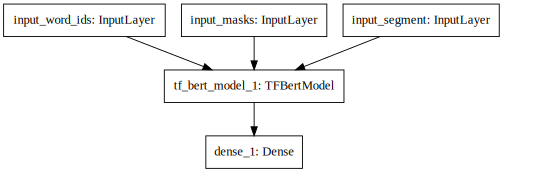

In [90]:
from IPython.display import SVG
from keras.utils import model_to_dot


SVG(model_to_dot(sentiment_model, dpi=65).create(prog='dot', format='svg'))

In [24]:
sentiment_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_segment (InputLayer)      [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 128, 768), ( 177853440   input_word_ids[0][0]             
                                                                 input_masks[0][0]     

감정 분석에 맞는 버트 모형을 리턴하는 함수를 정의하도록 하겠습니다.  
TPU를 활용하려면 함수로 묶어야 합니다.

In [25]:
# Rectified Adam 옵티마이저 사용
import tensorflow_addons as tfa
opt = tfa.optimizers.RectifiedAdam(lr=1.0e-5, weight_decay=0.0025)

In [26]:
def create_sentiment_bert():
  # 버트 pretrained 모델 로드
  model = TFBertModel.from_pretrained('bert-base-multilingual-cased')
  # 토큰 인풋, 마스크 인풋, 세그먼트 인풋 정의
  token_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_word_ids')
  mask_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_masks')
  segment_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_segment')
  # 인풋이 [토큰, 마스크, 세그먼트]인 모델 정의
  bert_outputs = model([token_inputs, mask_inputs, segment_inputs])

  bert_outputs = bert_outputs[1]
  sentiment_first = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02))(bert_outputs)
  sentiment_model = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], sentiment_first)

  sentiment_model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(), metrics = ['accuracy'])
  return sentiment_model

## 훈련 및 성능 검증

In [27]:
# TPU 실행 시
if TPU:
  strategy = tf.distribute.experimental.TPUStrategy(resolver)
# 함수를 strategy.scope로 묶어 줌
  with strategy.scope():
    sentiment_model = create_sentiment_bert()
  
  hist = sentiment_model.fit(train_x, train_y, epochs=10, shuffle=True, batch_size=100, validation_data=(test_x, test_y))
else:
  # GPU 모드로 훈련시킬 때
  sentiment_model = create_sentiment_bert()
  
  hist = sentiment_model.fit(train_x, train_y, epochs=10, shuffle=True, batch_size=100, validation_data=(test_x, test_y))

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/10
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


   2/1500 [..............................] - ETA: 9:05:11 - loss: 0.6976 - accuracy: 0.4950 WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0094s vs `on_train_batch_end` time: 0.1448s). Check your callbacks.


1500/1500 [==============================] - ETA: 0s - loss: 0.4531 - accuracy: 0.7774WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0042s vs `on_test_batch_end` time: 0.0401s). Check your callbacks.


1500/1500 [==============================] - 310s 207ms/step - loss: 0.4531 - accuracy: 0.7774 - val_loss: 0.3628 - val_accuracy: 0.8352
Epoch 2/10
1500/1500 [==============================] - 256s 171ms/step - loss: 0.3387 - accuracy: 0.8493 - val_loss: 0.3254 - val_accuracy: 0.8580
Epoch 3/10
1500/1500 [==============================] - 259s 173ms/step - loss: 0.2955 - accuracy: 0.8703 - val_loss: 0.3167 - val_accuracy: 0.8647
Epoch 4/10
1500/1500 [==============================] - 261s 174ms/step - loss: 0.2612 - accuracy: 0.8879 - val_loss: 0.3183 - val_accuracy: 0.8706
Epoch 5/10
1500/1500 [==============================] - 261s 174ms/step - loss: 0.2295 - accuracy: 0.9036 - val_loss: 0.3125 - val_accuracy: 0.8725
Epoch 6/10
1500/1500 [==============================] - 257s 171ms/step - loss: 0.2022 - accuracy: 0.9163 - val_loss: 0.3322 - val_accuracy: 0.8732
Epoch 7/10
1500/1500 [==============================] - 256s 171ms/step - loss: 0.1757 - accuracy: 0.9286 - val_loss: 0.359

In [33]:
def show_plots(history, plot_title=None, fig_size=None):
    assert type(history) is dict

    loss_vals = history['loss']
    val_loss_vals = history['val_loss'] if 'val_loss' in history.keys() else None
    epochs = range(1, len(history['accuracy']) + 1)

    f, ax = plt.subplots(nrows=1, ncols=2, figsize=((16, 4) if fig_size is None else fig_size))

    # plot losses on ax[0]
    ax[0].plot(epochs, loss_vals, color='navy', marker='o', linestyle=' ', label='Training Loss')
    if val_loss_vals is not None:
        ax[0].plot(epochs, val_loss_vals, color='firebrick', marker='*', label='Validation Loss')
        ax[0].set_title('Training & Validation Loss')
        ax[0].legend(loc='best')
    else:
        ax[0].set_title('Training Loss')

    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].grid(True)

    # plot accuracies
    acc_vals = history['accuracy']
    val_acc_vals = history['val_accuracy'] if 'val_accuracy' in history.keys() else None

    ax[1].plot(epochs, acc_vals, color='navy', marker='o', ls=' ', label='Training Accuracy')
    if val_acc_vals is not None:
        ax[1].plot(epochs, val_acc_vals, color='firebrick', marker='*', label='Validation Accuracy')
        ax[1].set_title('Training & Validation Accuracy')
        ax[1].legend(loc='best')
    else:
        ax[1].set_title('Training Accuracy')

    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].grid(True)

    if plot_title is not None:
        plt.suptitle(plot_title)

    plt.show()
    plt.close()

    # delete locals from heap before exiting (to save some memory!)
    del loss_vals, epochs, acc_vals
    if val_loss_vals is not None:
        del val_loss_vals
    if val_acc_vals is not None:
        del val_acc_vals

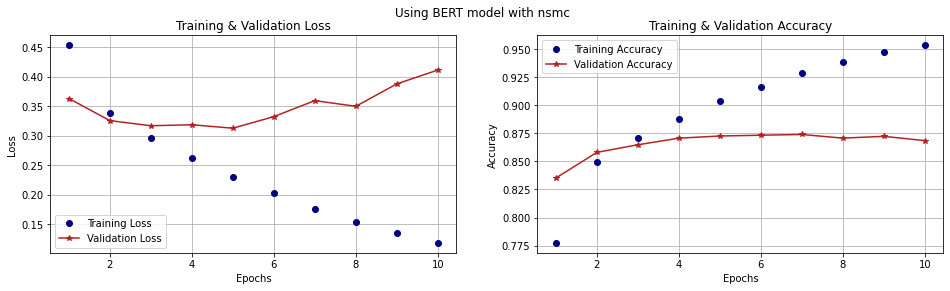

In [34]:
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import os
import itertools
show_plots(hist.history, plot_title='Using BERT model with nsmc')

훈련한 모델을 path에 저장
path는 임의로 지정해 주세요

In [ ]:
# PATH는 임의로 지정
path = "gdrive/My Drive/Colab Notebooks/naver_sentiment"

In [87]:
# sentiment_model.save_weights(path+"/huggingface_bert.h5")
# model = sentiment_model.to_json()
# with open("sentiment_model.json", "w") as json_file : 
#   json_file.write(model)
sentiment_model.save_weights("huggingface_bert.h5")


훈련 모델의 예측 성능을 F1 SCORE로 체크하기 위한 작업

In [35]:
def predict_convert_data(data_df):
    global tokenizer
    tokens, masks, segments = [], [], []
    
    for i in tqdm(range(len(data_df))):

        token = tokenizer.encode(data_df[DATA_COLUMN][i], max_length=SEQ_LEN, truncation=True, padding='max_length')
        num_zeros = token.count(0)
        mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros
        segment = [0]*SEQ_LEN

        tokens.append(token)
        segments.append(segment)
        masks.append(mask)

    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    return [tokens, masks, segments]

# 위에 정의한 convert_data 함수를 불러오는 함수를 정의
def predict_load_data(pandas_dataframe):
    data_df = pandas_dataframe
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_x = predict_convert_data(data_df)
    return data_x

test 데이터 예측하기

In [36]:
test_set = predict_load_data(test)

100%|██████████| 50000/50000 [00:16<00:00, 2955.36it/s]


In [37]:
test_set

[array([[  101,  8911,   100, ...,     0,     0,     0],
        [  101,   144, 11490, ...,     0,     0,     0],
        [  101,  9303, 21711, ...,     0,     0,     0],
        ...,
        [  101,  8924, 67527, ...,     0,     0,     0],
        [  101,  9666, 14423, ...,     0,     0,     0],
        [  101,  9246, 32537, ...,     0,     0,     0]]),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

In [38]:
with strategy.scope():
  preds = sentiment_model.predict(test_set)

In [39]:
# 부정이면 0, 긍정이면 1 출력
preds

array([[9.9162823e-01],
       [9.3006390e-01],
       [8.6810112e-01],
       ...,
       [8.8381541e-01],
       [5.7512755e-04],
       [4.4444266e-01]], dtype=float32)

우리가 훈련한 모델을 F1 SCORE를 바탕으로 성능 측정  
F1 SCORE는 precision과 recall을 가중평균하여 계산합니다  
recall은 (모델이 TRUE라고 판정한 것의 숫자)/(전체 TRUE의 숫자)  
precision은 (진짜 TRUE) / (모델이 TRUE라고 판정한 것의 숫자)

In [40]:
from sklearn.metrics import classification_report
y_true = test['label']
# F1 Score 확인
print(classification_report(y_true, np.round(preds,0)))

              precision    recall  f1-score   support

           0       0.89      0.84      0.86     24827
           1       0.85      0.90      0.87     25173

    accuracy                           0.87     50000
   macro avg       0.87      0.87      0.87     50000
weighted avg       0.87      0.87      0.87     50000



In [41]:
import logging
tf.get_logger().setLevel(logging.ERROR)

# 실제 데이터로 실습하기

문장 하나 하나를 가지고 실제로 분류해보도록 하겠습니다.  

In [42]:
def sentence_convert_data(data):
    global tokenizer
    tokens, masks, segments = [], [], []
    token = tokenizer.encode(data, max_length=SEQ_LEN, truncation=True, padding='max_length')
    
    num_zeros = token.count(0) 
    mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros 
    segment = [0]*SEQ_LEN

    tokens.append(token)
    segments.append(segment)
    masks.append(mask)

    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    return [tokens, masks, segments]

def movie_evaluation_predict(sentence):
    data_x = sentence_convert_data(sentence)
    predict = sentiment_model.predict(data_x)
    predict_value = np.ravel(predict)
    predict_answer = np.round(predict_value,0).item()
    
    if predict_answer == 0:
      print("(부정 확률 : %.2f) 부정적인 영화 평가입니다." % (1-predict_value))
    elif predict_answer == 1:
      print("(긍정 확률 : %.2f) 긍정적인 영화 평가입니다." % predict_value)

In [43]:
movie_evaluation_predict("보던거라 계속보고있는데 전개도 느리고 주인공인 은희는 한두컷 나오면서 소극적인모습에 ")

(부정 확률 : 1.00) 부정적인 영화 평가입니다.


In [44]:
movie_evaluation_predict("스토리는 확실히 실망이였지만 배우들 연기력이 대박이였다 특히 이제훈 연기 정말 ... 이 배우들로 이렇게밖에 만들지 못한 영화는 아쉽지만 배우들 연기력과 사운드는 정말 빛났던 영화. 기대하고 극장에서 보면 많이 실망했겠지만 평점보고 기대없이 집에서 편하게 보면 괜찮아요. 이제훈님 연기력은 최고인 것 같습니다")

(긍정 확률 : 1.00) 긍정적인 영화 평가입니다.


In [45]:
movie_evaluation_predict("남친이 이 영화를 보고 헤어지자고한 영화. 자유롭게 살고 싶다고 한다. 내가 무슨 나비를 잡은 덫마냥 나에겐 다시 보고싶지 않은 영화.")

(부정 확률 : 0.51) 부정적인 영화 평가입니다.


In [46]:
movie_evaluation_predict("보통입니다")

(긍정 확률 : 0.75) 긍정적인 영화 평가입니다.


# 새 섹션

In [47]:
test2 = pd.read_table("test.txt")

In [48]:
test2.head(5)

,label,document
0,5,다들친절하십니다
1,4,NaN
2,3,NaN
3,4,교수님들께서 잘해주시고 학교 생활도 좋아서 했습니다.
4,4,만족한다


In [49]:
test2 = predict_load_data(test2)

100%|██████████| 679/679 [00:00<00:00, 4156.90it/s]


In [50]:
with strategy.scope():
  preds = sentiment_model.predict(test2)

In [51]:
preds

array([[2.66820006e-02],
       [5.91363013e-01],
       [5.91363013e-01],
       [9.98434722e-01],
       [9.90125656e-01],
       [2.12741882e-01],
       [1.60895765e-03],
       [5.91363013e-01],
       [5.91363013e-01],
       [5.91363013e-01],
       [5.91363013e-01],
       [7.46968925e-01],
       [5.91363013e-01],
       [5.91363013e-01],
       [5.91363013e-01],
       [5.91363013e-01],
       [5.91363013e-01],
       [5.91363013e-01],
       [5.91363013e-01],
       [9.99058425e-01],
       [5.91363013e-01],
       [5.91363013e-01],
       [5.91363013e-01],
       [9.93326068e-01],
       [1.70219864e-03],
       [5.91363013e-01],
       [5.91363013e-01],
       [5.91363013e-01],
       [9.79158938e-01],
       [9.70020354e-01],
       [5.91363013e-01],
       [9.93183970e-01],
       [5.91363013e-01],
       [3.40725750e-01],
       [6.52132869e-01],
       [5.88512778e-01],
       [6.19926989e-01],
       [1.99756250e-01],
       [6.39152247e-04],
       [5.91363013e-01],
